# Evaluation

In [1]:
import os, sys
sys.path.insert(1, os.path.join(sys.path[0], '..'))

import torch
import pandas as pd
import matplotlib.pyplot as plt
from scipy.stats import pearsonr
from matplotlib.transforms import Affine2D
import matplotlib
from src import utils
from src.models import fishfactor
import pyro
import numpy as np
from sklearn.decomposition import PCA

matplotlib.rcParams.update({'font.size': 15})

In [2]:
n_cells = 20
subsample_fractions = [0.1, 0.3, 0.5, 0.8, 1.0]
bin_res_list = [5, 10, 20, 30, 40]

protrusion_genes = ['Cyb5r3', 'Sh3pxd2a', 'Ddr2', 'Net1', 'Trak2', 'Kif1c', 'Kctd10', 'Dynll2', 'Arhgap11a', 'Gxylt1', 'H6pd', 'Gdf11', 'Dync1li2', 'Palld', 'Ppfia1', 'Naa50', 'Ptgfr', 'Zeb1', 'Arhgap32', 'Scd1']
nucleus_perinucleus_genes = ['Col1a1', 'Fn1', 'Fbln2', 'Col6a2', 'Bgn', 'Nid1', 'Lox', 'P4hb', 'Aebp1', 'Emp1', 'Col5a1', 'Sdc4', 'Postn', 'Col3a1', 'Pdia6', 'Col5a2', 'Itgb1', 'Calu', 'Pdia3', 'Cyr61']
cytoplasm_genes = ['Ddb1', 'Myh9', 'Actn1', 'Tagln2', 'Kpnb1', 'Hnrnpf', 'Ppp1ca', 'Hnrnpl', 'Pcbp1', 'Tagln', 'Fscn1', 'Psat1', 'Cald1', 'Snd1', 'Uba1', 'Hnrnpm', 'Cap1', 'Ssrp1', 'Ugdh', 'Caprin1']
cluster_genes = protrusion_genes + nucleus_perinucleus_genes + cytoplasm_genes

data = pd.read_feather('../data/nih3t3/preprocessed_data.feather')
data = data[data.gene.isin(cluster_genes)]

data['group'] = data['experiment'].astype(str) + '_' + data['fov'].astype(str) + '_' + data['cell'].astype(str)

### FISHFactor

In [3]:
torch.random.manual_seed(1234)
np.random.seed(1234)

fishfactor_evaluation = []

for group in data.group.unique()[:n_cells]:
    cell_data = data[data.group==group]
    cell_data = cell_data[['x', 'y', 'gene', 'group']].rename(columns={'gene' : 'feature'})

    scaling_factor = max(cell_data.x.max() - cell_data.x.min(), cell_data.y.max() - cell_data.y.min())
    cell_data.x = (cell_data.x - cell_data.x.min()) / scaling_factor
    cell_data.y = (cell_data.y - cell_data.y.min()) / scaling_factor

    cell_data['group_id'], _ = pd.factorize(cell_data.group)
    cell_data['feature_id'], _ = pd.factorize(cell_data.feature)

    # full dataset, without subsampling
    results_full = torch.load('results/fishfactor/cell_%s/subsample_1.0.pkl' %group, map_location='cpu')
    
    cell_data_tensor = torch.tensor(cell_data[['x', 'y', 'feature_id', 'group_id']].values)
    grid = utils.grid(results_full['grid_resolution'])
    mask = utils.density_mask(cell_data_tensor, grid, results_full['min_density']).unsqueeze(0)

    w_full = results_full['pyro_params']['w_loc_raw'].cpu().detach().squeeze()
    w_full = torch.nn.Softplus()(w_full)

    pyro.clear_param_store()
    model = fishfactor.FISHFactor(
        data=cell_data,
        n_latents=results_full['K'],
        nu=results_full['nu'],
        n_inducing=results_full['n_inducing'],
        grid_resolution=results_full['grid_resolution'],
        min_density=results_full['min_density'],
        normalize_coordinates=False,
        device='cpu',
        masks=mask,
    )
    model.load_state_dict(results_full['state_dict'])

    for m in range(model.M):
        model.gp_list[m].load_state_dict(results_full['gp_state_dicts'][m])

    z_full = []
    for m in range(model.M):
        z_full.append(utils.gp_percentiles(model.gp_list[m], grid)[0].view(-1, model.grid_resolution, model.grid_resolution))
    z_full = torch.stack(z_full)
    z_full = torch.nn.Softplus()(z_full)
    z_full = z_full.squeeze()
    z_full *= mask

    for subsample_fraction in subsample_fractions:
        results_subsampled = torch.load('results/fishfactor/cell_%s/subsample_%s.pkl' %(group, subsample_fraction))
        w_subsampled = results_subsampled['pyro_params']['w_loc_raw'].cpu().detach().squeeze()
        w_subsampled = torch.nn.Softplus()(w_subsampled)

        pyro.clear_param_store()
        model = fishfactor.FISHFactor(
            data=cell_data,
            n_latents=results_subsampled['K'],
            nu=results_subsampled['nu'],
            n_inducing=results_subsampled['n_inducing'],
            grid_resolution=results_subsampled['grid_resolution'],
            min_density=results_subsampled['min_density'],
            normalize_coordinates=False,
            device='cpu',
            masks=mask,
        )
        model.load_state_dict(results_subsampled['state_dict'])

        for m in range(model.M):
            model.gp_list[m].load_state_dict(results_subsampled['gp_state_dicts'][m])

        z_subsampled = []
        for m in range(model.M):
            z_subsampled.append(utils.gp_percentiles(model.gp_list[m], grid)[0].view(-1, model.grid_resolution, model.grid_resolution))
        z_subsampled = torch.stack(z_subsampled)
        z_subsampled = torch.nn.Softplus()(z_subsampled)
        z_subsampled = z_subsampled.squeeze()
        z_subsampled *= mask

        inds, correlation = utils.optimal_assignment(z_full, z_subsampled, item_dim=0)
        z_subsampled = z_subsampled[inds]
        w_subsampled = w_subsampled[:, inds]

        z_corr = pearsonr(z_full.flatten(), z_subsampled.flatten())[0]
        w_corr = pearsonr(w_full.flatten(), w_subsampled.flatten())[0]

        df = pd.DataFrame({
            'cell' : group,
            'subsample_frac' : subsample_fraction,
            'w_corr' : w_corr,
            'z_corr' : z_corr,
        }, index=[len(fishfactor_evaluation) + 1])

        fishfactor_evaluation.append(df)
    
fishfactor_evaluation = pd.concat(fishfactor_evaluation)

### PCA

In [4]:
torch.random.manual_seed(1234)
np.random.seed(1234)

pca_evaluation = []

for bin_res in bin_res_list:
    for group in data.group.unique()[:n_cells]:
        cell_data = data[data.group==group]
        cell_data = cell_data[['x', 'y', 'gene', 'group']].rename(columns={'gene' : 'feature'})
        scaling_factor = max(cell_data.x.max() - cell_data.x.min(), cell_data.y.max() - cell_data.y.min())
        cell_data.x = (cell_data.x - cell_data.x.min()) / scaling_factor
        cell_data.y = (cell_data.y - cell_data.y.min()) / scaling_factor
        binned_data = utils.spatial_binning(cell_data, bin_res, bin_res).flatten(start_dim=-2).numpy()

        # full data
        pca = PCA(3, whiten=True).fit(binned_data.T)
        w_full = torch.tensor(pca.components_.T)
        z_full = torch.tensor(pca.transform(binned_data.T).T)

        for subsample_fraction in subsample_fractions:
            # create subsamples of the data and make sure that every gene occurs at least once
            subsample_size = int(subsample_fraction * len(cell_data))
            first_gene_occurence = cell_data.drop_duplicates('feature')
            other_data = cell_data.drop(index=first_gene_occurence.index)
            subsampled_other_data = other_data.sample(n=subsample_size - len(first_gene_occurence))
            subsampled_data = pd.concat([first_gene_occurence, subsampled_other_data])
            subsampled_binned_data = utils.spatial_binning(subsampled_data, bin_res, bin_res).flatten(start_dim=-2).numpy()
            pca = PCA(3, whiten=True).fit(subsampled_binned_data.T)
            w_subsampled = torch.tensor(pca.components_.T)
            z_subsampled = torch.tensor(pca.transform(subsampled_binned_data.T).T)

            inds, correlation = utils.optimal_assignment(z_full, z_subsampled, item_dim=0)
            z_subsampled = z_subsampled[inds]
            w_subsampled = w_subsampled[:, inds]

            z_corr = pearsonr(z_full.flatten(), z_subsampled.flatten())[0]
            w_corr = pearsonr(w_full.flatten(), w_subsampled.flatten())[0]

            df = pd.DataFrame({
                'cell' : group,
                'subsample_frac' : subsample_fraction,
                'bin_res' : bin_res,
                'w_corr' : w_corr,
                'z_corr' : z_corr,
            }, index=[len(pca_evaluation) + 1])

            pca_evaluation.append(df)

pca_evaluation = pd.concat(pca_evaluation)

### Comparison

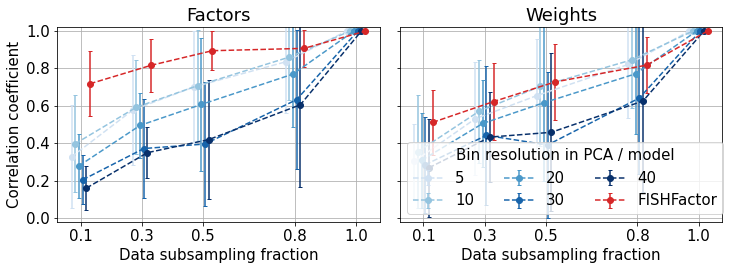

In [5]:
fig, axs = plt.subplots(1, 2, figsize=(11, 4), sharey=True)

x_shift = np.linspace(-0.03, 0.03, 6)
color_list = plt.cm.get_cmap('Blues')(np.linspace(0.2, 1, 5))

# PCA
for i, binres in enumerate(bin_res_list):
    evaluation_subset = pca_evaluation[(pca_evaluation.bin_res==binres)]
    z_corr_group = evaluation_subset.groupby('subsample_frac').z_corr
    w_corr_group = evaluation_subset.groupby('subsample_frac').w_corr

    transform = Affine2D().translate(x_shift[i], 0.0) + axs[0].transData
    axs[0].errorbar(z_corr_group.mean().index, z_corr_group.mean(), yerr=z_corr_group.std(), label=binres, marker='o', linestyle='--', transform=transform, c=color_list[i], capsize=2)
    transform = Affine2D().translate(x_shift[i], 0.0) + axs[1].transData
    axs[1].errorbar(w_corr_group.mean().index, w_corr_group.mean(), yerr=w_corr_group.std(), label=binres, marker='o', linestyle='--', transform=transform, c=color_list[i], capsize=2)

# FISHfactor
z_corr_group = fishfactor_evaluation.groupby('subsample_frac').z_corr
w_corr_group = fishfactor_evaluation.groupby('subsample_frac').w_corr
transform = Affine2D().translate(x_shift[-1], 0.0) + axs[0].transData
axs[0].errorbar(z_corr_group.mean().index, z_corr_group.mean(), yerr=z_corr_group.std(), label='FISHFactor', marker='o', linestyle='--', transform=transform, c='C3', capsize=2)
transform = Affine2D().translate(x_shift[-1], 0.0) + axs[1].transData
axs[1].errorbar(w_corr_group.mean().index, w_corr_group.mean(), yerr=w_corr_group.std(), label='FISHFactor', marker='o', linestyle='--', transform=transform, c='C3', capsize=2)

axs[0].set_title('Factors')
axs[0].set_xlabel('Data subsampling fraction')
axs[1].set_title('Weights')
axs[1].set_xlabel('Data subsampling fraction')
axs[0].set_ylabel('Correlation coefficient')
axs[0].set_ylim(-0.02, 1.02)
axs[1].set_ylim(-0.02, 1.02)
axs[0].set_xticks(subsample_fractions)
axs[1].set_xticks(subsample_fractions)
axs[0].grid()
axs[1].grid()
axs[1].legend(title='Bin resolution in PCA / model', ncol=3)

plt.tight_layout()
plt.show()